# Notebook for visualizing the results of a stylegan3 training


In [11]:
import os, json
import matplotlib.pyplot as plt

results_dir = "training-runs/OITAVEN"
experiment_name = "00000-stylegan3-t-oitaven-gpus2-batch64-gamma0.125"
file_name = "stats.jsonl"

file_path = os.path.join(results_dir, experiment_name, file_name)
if not os.path.isfile(file_path):
    print(f"Error: The file {file_path} does not exist.")

# Labels for the classes
class_labels = range(1, 11)

In [12]:
import numpy as np


def read_jsonl(file_path):
    """
    Reads a JSONL file and returns a list of parsed JSON objects.
    """
    with open(file_path, "r") as f:
        return [json.loads(line) for line in f]


def extract_metrics(jsonl_data, class_labels):
    """
    Extracts metrics from the JSONL data into a dictionary of lists.
    """
    metric_keys = [
        "Loss/scores/fake",
        "Loss/signs/fake",
        "Loss/G/loss",
        "Loss/scores/real",
        "Loss/signs/real",
        "Loss/D/loss",
        "Loss/r1_penalty",
        "Loss/D/reg",
        "Progress/tick",
        "Progress/kimg",
        "Timing/total_sec",
        "Timing/sec_per_tick",
        "Timing/sec_per_kimg",
        "Timing/maintenance_sec",
        "Resources/cpu_mem_gb",
        "Resources/peak_gpu_mem_gb",
        "Resources/peak_gpu_mem_reserved_gb",
        "Progress/augment",
        "Timing/total_hours",
        "Timing/total_days",
        "Timing/Gboth",
        "Timing/Dmain",
        "Timing/Dreg",
        "timestamp",
    ]
    metric_keys.extend([f"Loss/classification/{c}" for c in class_labels])
    metrics = {key: [] for key in metric_keys}

    for entry in jsonl_data:
        for key in metric_keys:
            if key in entry:
                # Handle nested keys with "mean" values
                if isinstance(entry[key], dict) and "mean" in entry[key]:
                    metrics[key].append(entry[key]["mean"])
                else:
                    metrics[key].append(entry[key])
            else:
                metrics[key].append(None)  # Handle missing keys gracefully

    return metrics


def extract_classification_metrics(jsonl_data, class_labels):
    """
    Extracts classification metrics (mean and num) from the JSONL data into a dictionary.
    """
    classification_keys = [f"Loss/classification/{c}" for c in class_labels]
    metrics = {key: {"mean": [], "num": []} for key in classification_keys}

    for entry in jsonl_data:
        for key in classification_keys:
            if key in entry:
                # Handle nested keys with "mean" and "num" values
                if isinstance(entry[key], dict):
                    metrics[key]["mean"].append(entry[key].get("mean", None))
                    metrics[key]["num"].append(entry[key].get("num", None))
                else:
                    metrics[key]["mean"].append(None)
                    metrics[key]["num"].append(None)
            else:
                metrics[key]["mean"].append(None)
                metrics[key]["num"].append(None)

    return metrics


def plot_metric(data, metrics=["Loss/D/loss"], x_axis="Progress/kimg", marker="o"):
    """
    Plots a specific metric against the x-axis (default is Progress/kimg).
    """
    for metric in metrics:
        if metric not in data:
            print(f"Warning: Metric {metric} not found in data.")
            return

    if x_axis not in data:
        print(f"Warning: X-axis {x_axis} not found in data.")
        return

    plt.figure(figsize=(10, 5))
    for metric in metrics:
        plt.plot(data[x_axis], data[metric], label=metric, marker=marker)
    plt.xlabel(x_axis)
    plt.ylabel("Metrics Value")
    plt.title(",".join(metrics) + " vs " + x_axis)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


def print_accuracies_per_class(data, class_labels, last_ticks=10):
    """
    Prints the accuracies for each class from the classification loss metrics.
    """
    classification_keys = [f"Loss/classification/{c}" for c in class_labels]
    accuracies = [data[metric][-last_ticks:] for metric in classification_keys]
    accuracies = np.array(accuracies)
    print(f"Last {last_ticks} accuracies per class:")
    for class_label, acc in zip(class_labels, accuracies):
        print(f"Class {class_label}: {acc}")
    print(f"Average accuracies over the last {last_ticks} ticks: {np.mean(accuracies, axis=0)}")


def compute_avg_accuracy(data, clean_nan, class_labels):
    """
    Computes the average accuracy from the classification loss metrics.
    """
    classification_keys = [f"Loss/classification/{c}" for c in class_labels]
    accuracies = [data[metric] for metric in classification_keys]
    if clean_nan:
        accuracies = [np.nan_to_num(acc, nan=0) for acc in accuracies]

    accuracies = np.array(accuracies)
    return np.mean(accuracies, axis=0), np.std(accuracies, axis=0)


def compute_overall_accuracy(classification_metrics):
    """
    Computes the overall accuracy from the classification metrics.
    """
    total_correct = None
    total_samples = None

    for key, values in classification_metrics.items():
        means = np.array(values["mean"])
        means = np.nan_to_num(means, nan=0.0)
        nums = np.array(values["num"])

        if total_correct is None:
            total_correct = np.zeros_like(means)
            total_samples = np.zeros_like(nums)

        total_correct += means * nums
        total_samples += nums

    return total_correct / total_samples


def plot_accuracies(data, class_labels=range(10), plot_std_in_avg_accuracy=True, plot_type="both"):
    """
    Plots the overall accuracy, average accuracy, or both over time.

    Args:
        data (dict): Dictionary containing the metrics data.
        class_labels (list): List of class labels (default is range(10)).
        plot_std_in_avg_accuracy (bool): Whether to plot the standard deviation in the average accuracy plot.
        plot_type (str): Type of plot to generate. Options are:
                         - "overall": Plot only overall accuracy.
                         - "average": Plot only average accuracy.
                         - "both": Plot both overall and average accuracy in the same plot.
    """
    if plot_type not in ["overall", "average", "both"]:
        raise ValueError("Invalid plot_type. Choose from 'overall', 'average', or 'both'.")

    # Plot Overall Accuracy
    if plot_type in ["overall", "both"]:
        overall_accuracy = data["overall_accuracy"]
        plt.figure(figsize=(10, 5))
        plt.plot(data["Progress/kimg"], overall_accuracy, label="Overall Accuracy", marker="o")
        plt.xlabel("Progress/kimg")
        plt.ylabel("Overall Accuracy")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if plot_type == "overall":
            plt.title("Overall Accuracy vs Progress/kimg")
            plt.show()

    # Compute Average Accuracy and Standard Deviation
    if plot_type in ["average", "both"]:
        avg_accuracy, std_accuracy = compute_avg_accuracy(data, clean_nan=True, class_labels=class_labels)

        if plot_type == "average":
            plt.figure(figsize=(10, 5))
        plt.plot(data["Progress/kimg"], avg_accuracy, label="Average Accuracy", marker="o")
        if plot_std_in_avg_accuracy:
            plt.fill_between(
                data["Progress/kimg"],
                avg_accuracy - std_accuracy,
                avg_accuracy + std_accuracy,
                alpha=0.2,
                label="Standard Deviation",
            )
        plt.xlabel("Progress/kimg")
        plt.ylabel("Average Accuracy")
        if plot_type == "average":
            plt.title("Average Accuracy vs Progress/kimg")
        else:
            plt.title("Overall and Average Accuracy vs Progress/kimg")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.close("all")

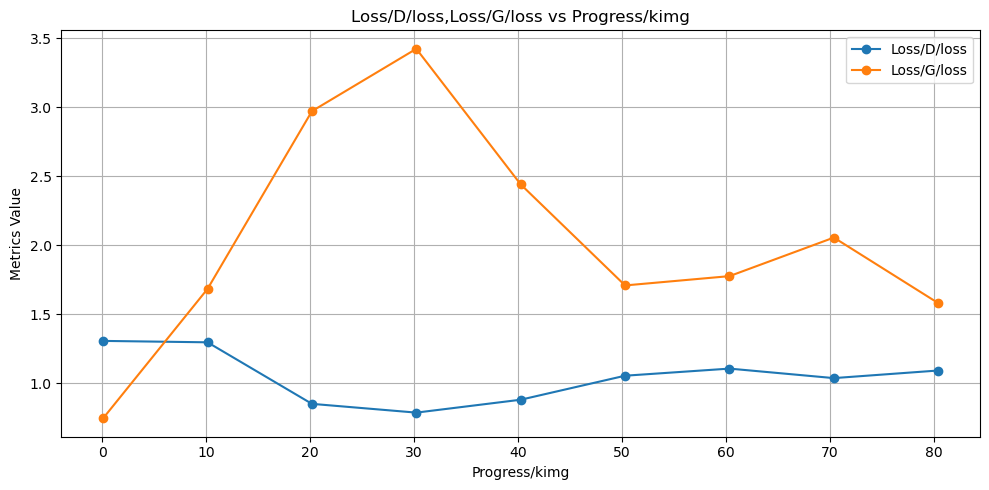

In [13]:
jsonl_data = read_jsonl(file_path)
metrics = extract_metrics(jsonl_data, class_labels=class_labels)
plot_metric(metrics, metrics=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg")

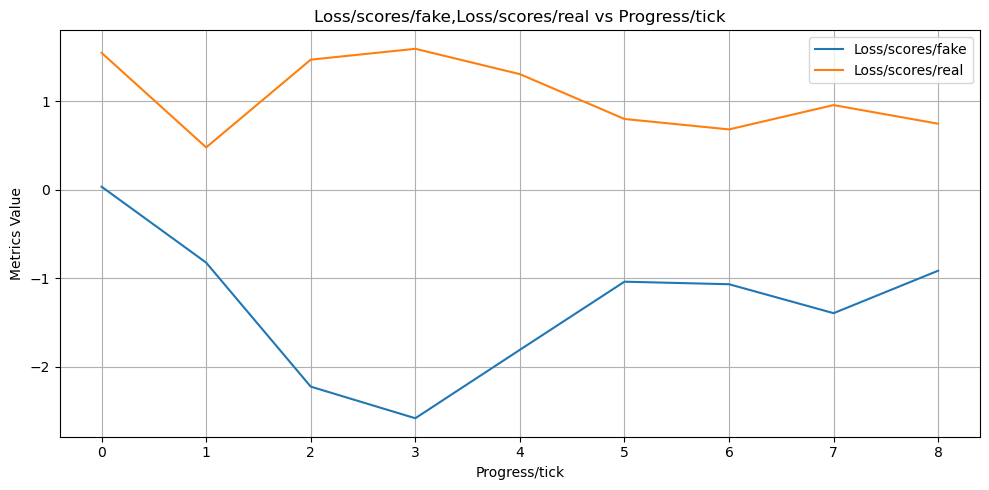

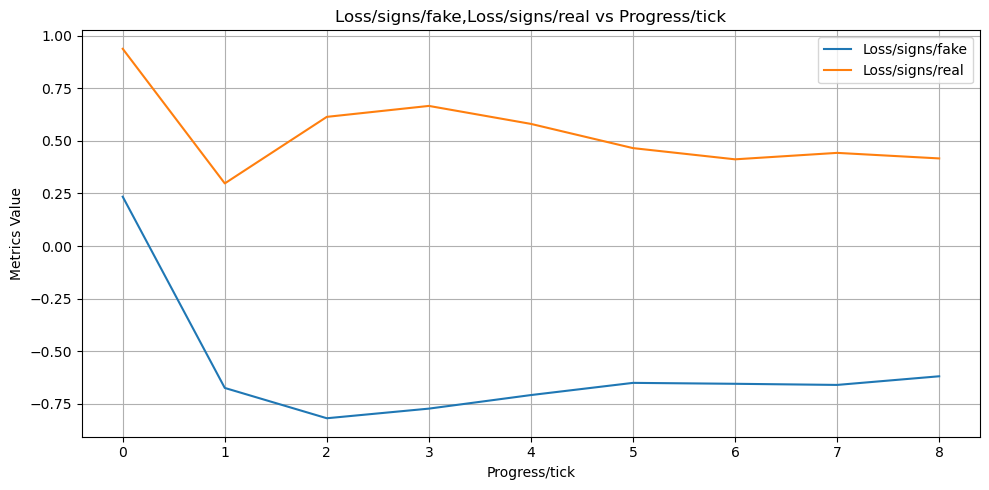

In [14]:
plot_metric(metrics, metrics=["Loss/scores/fake", "Loss/scores/real"], x_axis="Progress/tick", marker=None)
plot_metric(metrics, metrics=["Loss/signs/fake", "Loss/signs/real"], x_axis="Progress/tick", marker=None)

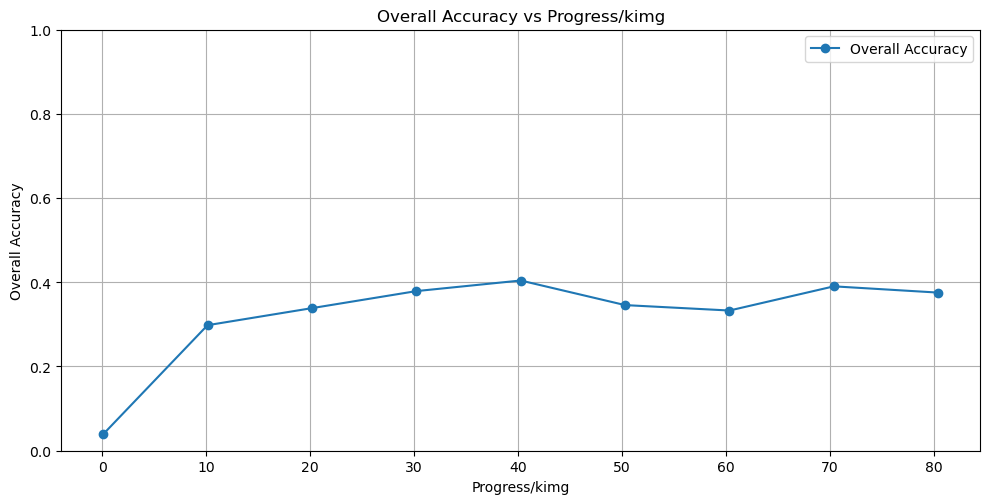

In [15]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
metrics["overall_accuracy"] = compute_overall_accuracy(classification_metrics)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=False,
    plot_type="overall",
)

Last 10 accuracies per class:
Class 1: [0.         0.13270142 0.03355705 0.06695464 0.17342342 0.16738197
 0.12723214 0.12837838 0.15277778]
Class 2: [0.5        0.01652893 0.02575107 0.08943089 0.02325581 0.01310044
 0.01731602 0.         0.01214575]
Class 3: [0.5        0.04878049 0.00625    0.         0.10429448 0.40804598
 0.23033708 0.125      0.0052356 ]
Class 4: [       nan 0.         0.         0.02985075 0.15492958 0.1625
 0.28571429 0.27142857 0.23076923]
Class 5: [0.         0.55042017 0.61818182 0.5        0.02057613 0.05045872
 0.0460251  0.         0.02654867]
Class 6: [       nan 0.2        0.20261438 0.36054422 0.2781457  0.27922078
 0.22794118 0.23972603 0.15384615]
Class 7: [0.02       0.38972542 0.29943837 0.24218289 0.35505751 0.5423981
 0.49568067 0.44025898 0.52982456]
Class 8: [0.         0.26337006 0.34286471 0.68795473 0.67397622 0.24241603
 0.31945191 0.4787573  0.4248927 ]
Class 9: [0.         0.29484536 0.68257261 0.69361702 0.39651416 0.33333333
 0.11691023

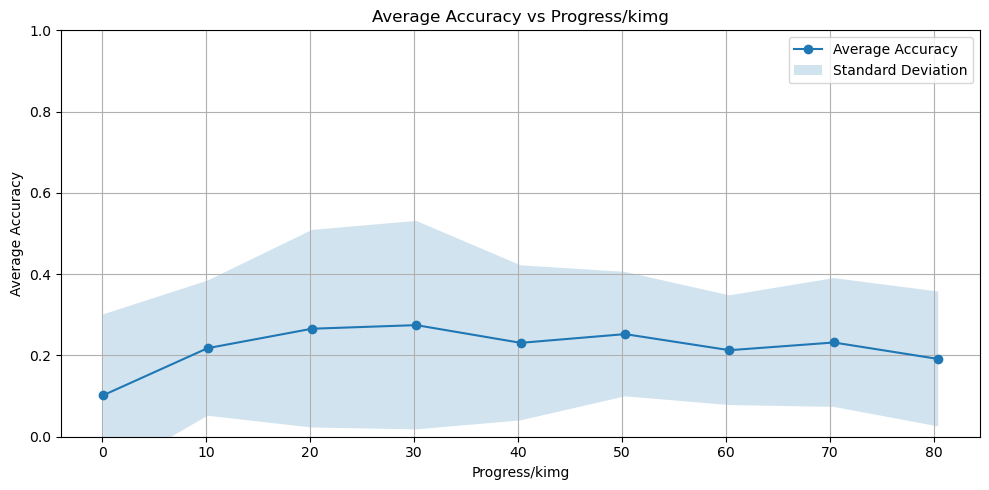

In [16]:
print_accuracies_per_class(metrics, class_labels, last_ticks=10)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="average",
)

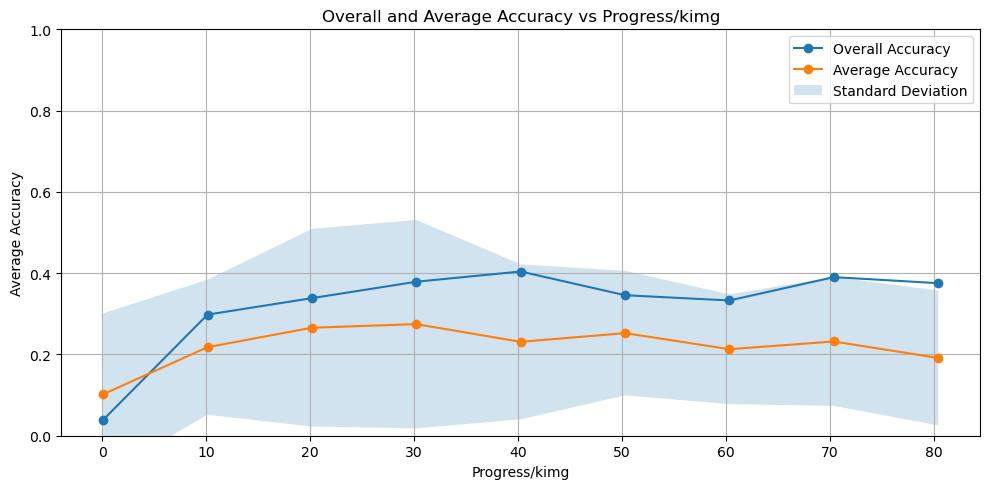

In [17]:
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="both",
)

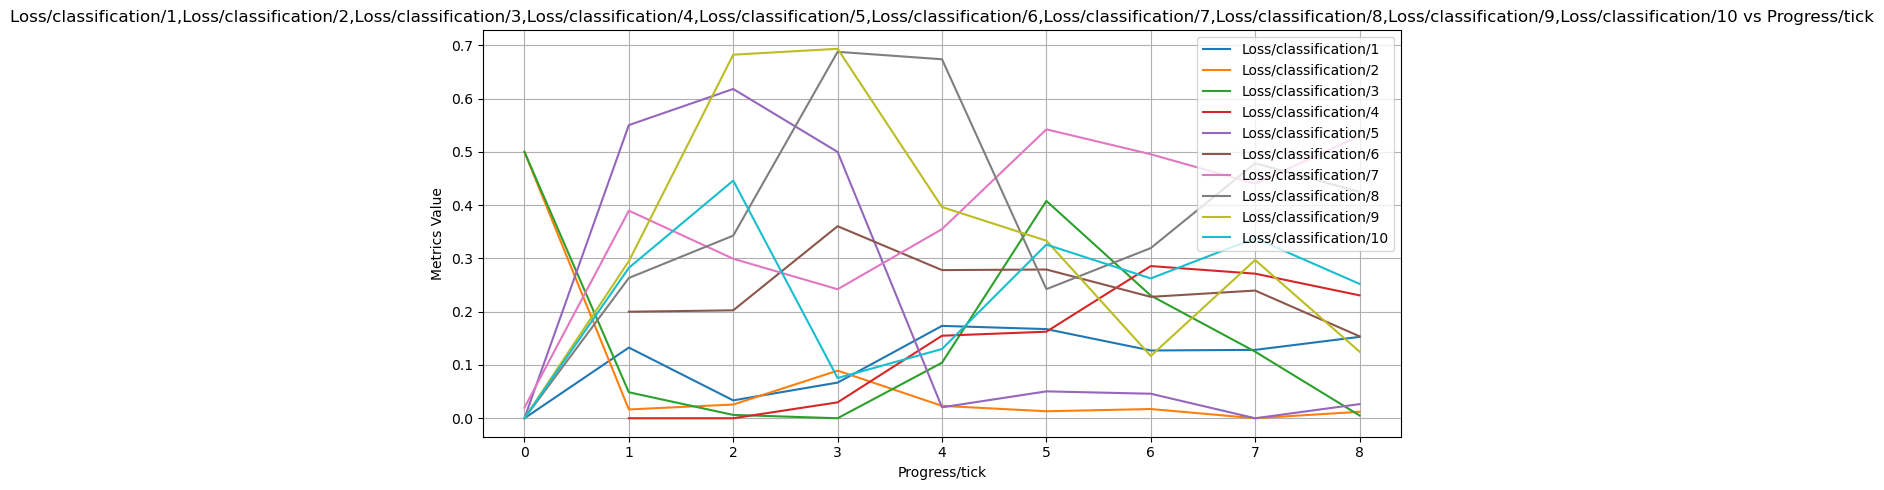

In [18]:
plot_metric(metrics, metrics=[f"Loss/classification/{c}" for c in class_labels], x_axis="Progress/tick", marker=None)